# Annular Spectra of Extended Sources

This section aims to run through the basics of how to generate, and interact with, annular spectra of extended sources in XGA. This will include running XSPEC fits on the annuli, as you would for a galaxy cluster were you would like to measure a projected temperature profile, and an apec normalisation profile (which was used in [gas density profiles tutorial](../advanced_tutorials/cluster_gas.html).

I'll also demonstrate how to use the visualisation abilities which are built in the AnnularSpectra class, how to access results from XSPEC fits for each annulus individually, and how to retrieve annular spectra from where they have been stored in a source object.

In [1]:
from xga.samples import ClusterSample
from xga.sas import spectrum_set
from xga.xspec import single_temp_apec_profile

from astropy.units import Quantity
import numpy as np
import pandas as pd

Yet again we will be using these four clusters from the SDSSRM-XCS sample, the same clusters that were used for the [gas density profiles tutorial](../advanced_tutorials/cluster_gas.html) and the [spectroscopy tutorial](../tutorials/spectroscopy.html). There was no particular rationale behind selecting these particular clusters for this demonstration, other than that the observations of them of are a high enough quality that there shouldn't be any problem generating and fitting the spectra.

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']
cluster_data = np.array([['XCSSDSS-124', 0.80057775, -6.0918182, 0.251, 1220.11, 1777.06, 109.55, 4.49],
                         ['XCSSDSS-2789', 0.95553986, 2.068019, 0.11, 1039.14, 1519.79, 38.90, 2.83],
                         ['XCSSDSS-290', 2.7226392, 29.161021, 0.338, 935.58, 1359.37, 105.10, 5.99],
                         ['XCSSDSS-134', 4.9083898, 3.6098177, 0.273, 1157.04, 1684.15, 108.60, 4.79]])

# Possibly I'm overcomplicating this by making it into a dataframe, but it is an excellent data structure,
#  and one that is very commonly used in my own analyses.
sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']].astype(float)

# Defining the sample of four XCS-SDSS galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values, r200=Quantity(sample_df["r200"].values, "kpc"),
                         r500=Quantity(sample_df["r500"].values, 'kpc'), richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values)

Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


## Manually generating sets of annular spectra

There are several functions in XGA designed for generating particular types of profile from a set of annular spectra, and in most cases they will have algorithms designed to automatically decide where they're going to place annuli. However, it is entirely possible that users will want to decide for themselves where exactly the annuli should be placed, and as such I will initially demonstrate how to manually generate annular spectra for our sample.

The `spectrum_set()` function is where XGA generated sets of annular spectra by setting up the annular regions (including the removal of interloper sources), running all the SAS commands, and then combining the resulting files into a single `AnnularSpectra` [instance](../../xga.products.html#xga.products.spec.AnnularSpectra). The full documentation for the function can be found [here](../../xga.sas.html#xga.sas.spec.spectrum_set), but it is quite simple to use, with the most important argument being `radii`, where you specify what annuli should be generated.

When deciding where the annuli should be placed, please bear in mind that the `radii` argument expects information on the **boundaries** of the annuli, so should start at zero if you wish the innermost annulus to be a circle. Here we set up four sets of annuli, one for each cluster:

In [3]:
ann_rads = [np.linspace(0, 1, 5)*demo_smp[0].r500, np.linspace(0, 1.2, 6)*demo_smp[1].r500, 
            Quantity([0, 100, 200, 300, 1200], 'kpc'), np.linspace(0, 1, 6)*demo_smp[3].r500]
ann_rads

[<Quantity [   0.    ,  305.0275,  610.055 ,  915.0825, 1220.11  ] kpc>,
 <Quantity [   0.    ,  249.3936,  498.7872,  748.1808,  997.5744,
            1246.968 ] kpc>,
 <Quantity [   0.,  100.,  200.,  300., 1200.] kpc>,
 <Quantity [   0.   ,  231.408,  462.816,  694.224,  925.632, 1157.04 ] kpc>]

These radii were chosen essentially randomly, and have no physical meaning or importance, we merely wish to demonstrate the different ways you might want to define sets of annular boundary radii. Now that we've set those up, all we need to do is pass them into the `spectrum_set()` function, and they will be generated. This function will always generate a spectrum between the first and last entries for each set of radii as well, as it is often convenient to normalise values measured from these spectra by a global value. 

The background spectrum defined for the set of annular spectra is generated between `back_inn_rad_factor`\*outermost-radius and `back_out_rad_factor`\*outermost radius - those factors were set when you initially defined the source or sample:

In [4]:
spectrum_set(demo_smp, radii=ann_rads)

Generating products of type(s) spectrum: 100%|██████████| 12/12 [55:25<00:00, 277.13s/it] 
Generating products of type(s) annular spectrum set components: 100%|██████████| 54/54 [28:05<00:00, 31.22s/it]  


## XSPEC fit to annular spectra

Now we want to fit plasma emission models to the set of spectra (there will be multiple spectra per annulus if there are multiple observations of the source), just as we fit a model to the global spectra we produced in the [spectroscopy tutorial](../tutorials/spectroscopy.html). Again we'll be making use of the XGA XSPEC interface, and the fitting process works in exactly the same way for the constant\*tbabs\*apec model that describes absorbed plasma emission from a cluster. In this case however, we use the `single_temp_apec_profile()` function (look [here](../../xga.xspec.html#xga.xspec.fit.profile.single_temp_apec_profile) for documentation).

To run a default fit with this model to our set of clusters, we just need to pass the same list of annular boundaries into the fitting function (currently the only model that can be used to fit these profiles):

In [5]:
single_temp_apec_profile(demo_smp, radii=ann_rads)

Running XSPEC Fits: 100%|██████████| 18/18 [00:33<00:00,  1.87s/it]


If we hadn't already generated these spectra, this function would actually have run the `spectrum_set()` function for us, then fit them as we requested, but I wished to demonstrate the use of the annular spectra generation function.

## Fetching annular spectra from a source

As is the case for most XGA products, there is a specific method to retrieve annular spectra from a source object, in this case the `get_annular_spectra` method (you can find the full documentation [here](../../xga.sources.html#xga.sources.base.BaseSource.get_annular_spectra)). Since we know a priori the radii we used to generate the annular spectra, all we need to do here is to pass those radii and the correct set of annular spectra will be fetched:

In [6]:
cur_ann_spec = demo_smp[0].get_annular_spectra(radii=ann_rads[0])
cur_ann_spec

Please note that each set of annular spectra is issued a unique 'set id' when it is generated, and if you already knew that identifying number you could pass it to the `get_annular_spectra()` method through the `set_id` argument and retrieve the correct set of annular spectra.

## Visualising annular spectra

Now that we've generated, fitted, and retrieved these annular spectra, we might want to visualise the data somehow. Several methods to do just that have been implemented in the `AnnularSpectra` class. 

### An individual annulus with `view_annulus()`

The first is akin to the `view()` method which is present in the `Spectrum` class, although in this case all spectra for a single annulus are shown. You need to pass the annulus ID (for instance the innermost annulus would be 0, the next 1, etc.), and the model that was fitted (in this case constant\*tbabs\*apec):

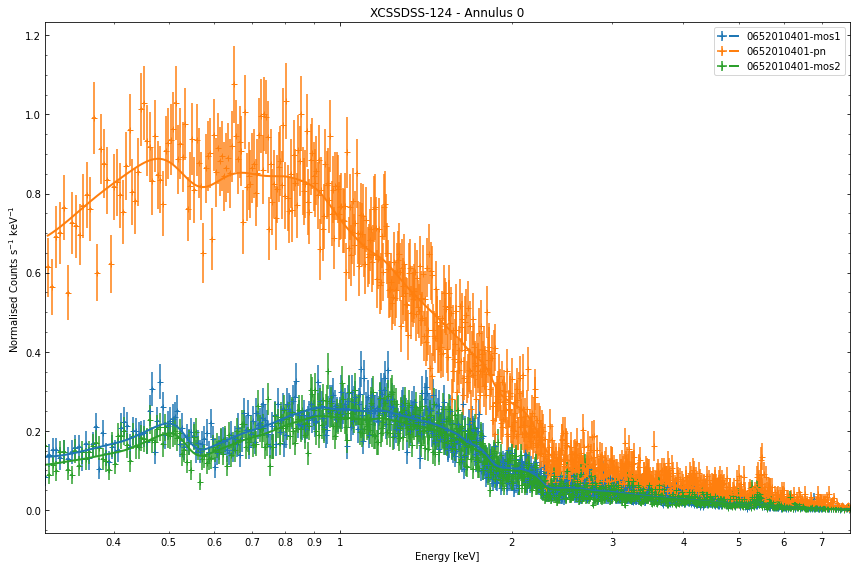

In [7]:
# Just choosing the first annulus for not particular reason
cur_ann_spec.view_annulus(0, 'constant*tbabs*apec')

### A set of annuli for a particular ObsID-Instrument with `view_annuli()`

The next method lets you see a whole set of annular spectra, for a single ObsID-Instrument combination. The `view_annuli()` method requires a little more information, as you have to pass an ObsID and instrument as well as the model that was fitted. This visualisation is in 3D, so you can also set the `elevation_angle` and `azimuthal_angle` to change perspective. I also use the `instruments` property that each source object has to remind myself which ObsIDs and instruments are associated with this source:

In [8]:
demo_smp[0].instruments

{'0652010401': ['pn', 'mos1', 'mos2']}

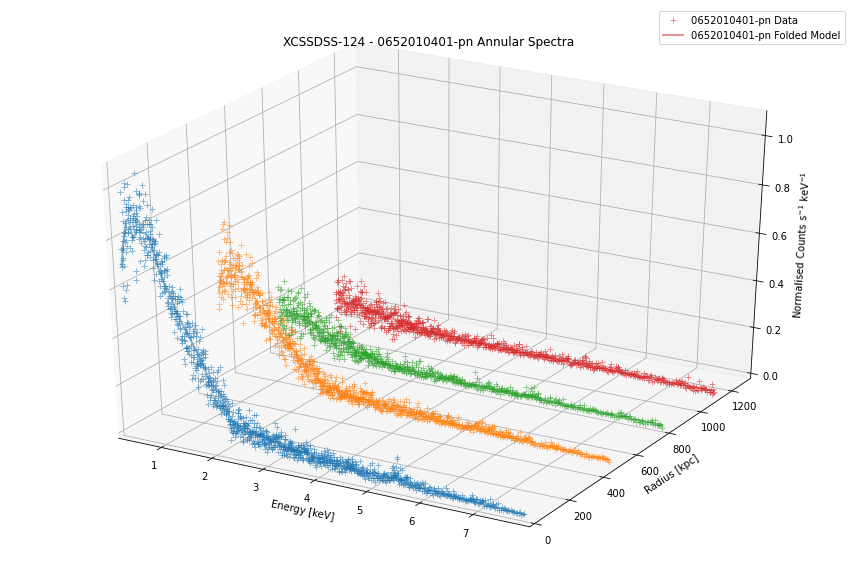

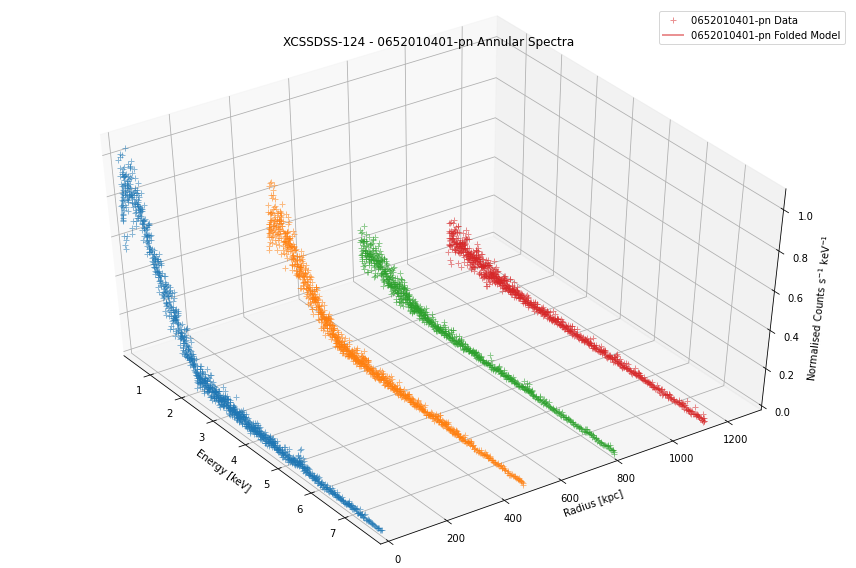

In [9]:
cur_ann_spec.view_annuli('0652010401', 'pn', 'constant*tbabs*apec')

# Changing the perspective, just a demonstration I'm not saying this is more useful
cur_ann_spec.view_annuli('0652010401', 'pn', 'constant*tbabs*apec', elevation_angle=45, azimuthal_angle=-35)

### All fitted models for all annuli with `view()`

Another three dimensional view method, but rather than a set of annular spectra for a specific ObsID-instrument combination, this will show the fitted models for **all** ObsID-instrument combinations associated with this `AnnularSpectra` instance. No data points are plotted here because it makes the figure far too confusing. The same angle arguments can be passed to change the perspective of the plot:

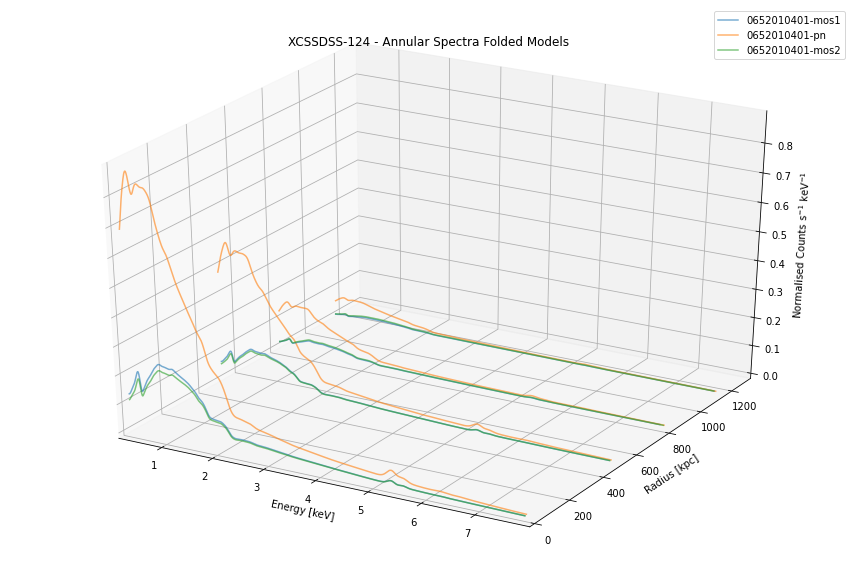

In [10]:
cur_ann_spec.view('constant*tbabs*apec')

## Retrieving a spectrum from an `AnnularSpectra` instance

An `AnnularSpectra` instance is what is termed an 'aggregate product' in XGA; that is to say that its actually a container for multiple individual product instances (in this case `Spectrum` instances). That means that those individual instances (with all their built in features and information) are stored within the aggregate product, and can be retrieved with a convenient get method (`get_spectra()` in this case).

So if we decided we wanted to retrieve the 0652010401-pn spectrum for the innermost annulus, we would run this command:

In [11]:
ind_spec = cur_ann_spec.get_spectra(0, '0652010401', 'pn')

Then we could decide to view that spectrum, if we wanted:

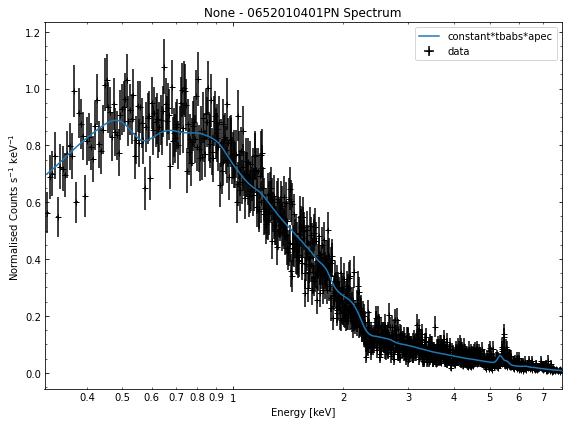

In [12]:
ind_spec.view()

We aren't limited to retrieving one spectrum at a time however, if we wanted to we could grab a list of all the `Spectrum` objects that make up the first annulus:

In [13]:
cur_ann_spec.get_spectra(0)

If, for some reason, you wanted to do the same thing but for **all** spectra in the `AnnularSpectra` object, you could just use the `all_spectra` property: 

In [14]:
cur_ann_spec.all_spectra

## Retrieving fit results and luminosities

Retrieving fit results is as simple as calling another get method, `get_results`. You must specify which annulus you want to get the results for, as well as the model that was fitted, and optionally you can specify the name of the parameter that you particularly want to grab:

In [15]:
cur_ann_spec.get_results(0, 'constant*tbabs*apec')

{'kT': array([7.41271   , 0.12935868, 0.1301684 ]),
 'norm': array([4.2421700e-03, 3.3772432e-05, 3.4043752e-05]),
 'factor': array([[0.958273  , 0.00932076, 0.00942246],
        [1.0042    , 0.01143088, 0.01155637]])}

In [16]:
cur_ann_spec.get_results(3, 'constant*tbabs*apec', 'norm')

array([3.66600000e-04, 2.16666992e-05, 2.19063438e-05])

The behaviour of the method with which you fetch luminosities (`get_luminosities`) is much the same, but instead of optionally specifying a parameter name you can pass `lo_en` and `hi_en` values to get back a luminosity measured within specific energy limits:

In [17]:
cur_ann_spec.get_luminosities(0, 'constant*tbabs*apec')

{'bound_0.5-2.0': <Quantity [2.95390183e+44, 1.75799566e+42, 1.42047898e+42] erg / s>,
 'bound_0.01-100.0': <Quantity [1.16941378e+45, 1.26719656e+43, 1.23961762e+43] erg / s>}

In [18]:
cur_ann_spec.get_luminosities(0, 'constant*tbabs*apec', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

<Quantity [2.95390183e+44, 1.75799566e+42, 1.42047898e+42] erg / s>

## Other useful information about `AnnularSpectra`

Here I will quickly run through other useful pieces of information which are stored in an AnnularSpectra object. The first piece of information that can be handy is the number of annuli in a given spectrum, for which you can just use the standard Python `len()` function (or the `num_annuli` property):

In [19]:
print(len(cur_ann_spec))
print(cur_ann_spec.num_annuli)

4
4


There is also a property that will return the set id that, as I mentioned earlier, is a unique identifier that can be used to retrieve the `AnnularSpectra` object:

In [20]:
cur_ann_spec.set_ident

1295248

The boundary radii which were used to generated the set of annular spectra initially are given by the `radii` property:

In [21]:
cur_ann_spec.radii

<Quantity [0.        , 0.02094309, 0.04188617, 0.06282926, 0.08377235] deg>

And finally, the `obs_ids` property gives a list of all the ObsIDs that went into the `AnnularSpectra` (it is essentially the same as the `obs_ids` property of `BaseSource`), and `AnnularSpectra` has an `instruments` property that performs the same function as the `instruments` property of `BaseSource`:

In [22]:
cur_ann_spec.obs_ids

['0652010401']

In [23]:
cur_ann_spec.instruments

{'0652010401': ['mos1', 'pn', 'mos2']}